<p style="font-size:40px">4. Adjusting Threshold</p> <br>


<p style="font-family:'Courier New'">Pada jupyter notebook ini, saya akan menentukan threshold terbaik menurut masalah bisnis yang dihadapi. Dimana pada kasus ini, saya menginginkan model yang memiliki recall yang baik. 

><p style="font-family:'Courier New'">Tujuan objektif dari jupyter notebook ini adalah menentukan threshold untuk model agar memiliki nilai recall yang tinggi.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, plot_confusion_matrix, confusion_matrix, classification_report, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, binarize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import binarize, OneHotEncoder

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Dataset Splitting

In [3]:
bank = pd.read_csv('bank_clean.csv')

X = bank.drop('y', axis = 1)
y = bank['y'].map({'yes' : 1, 'no' : 0})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

# Preprocessing

In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age']),
        ('cat', categorical_transformer, ['month','pdays'])])

# Evaluation Metrics

<p style="font-family:'Courier New'">Evaluation Metrics yang digunakan tidak banyak, hanya precision dan recall. Karena seperti yang telah disinggung sebelumnya, saya ingin menentukan model terbaik dari perspektif bisnis. 

In [5]:
def evaluationMetrics(y_test, y_pred):
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))

In [6]:
def find_thresh(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:,1]
    prec, recall, thresh = precision_recall_curve(y_test, y_proba)
    fScore = (2 * prec * recall) / (prec + recall)
    idx = np.argmax(fScore)
    
    ##plot
    plt.figure(figsize=(8, 8))
    plt.title("Precision-Recall Curve")
    plt.plot(thresh, prec[:-1], "b-", label="Precision")
    plt.plot(thresh, recall[:-1], "r-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')
    
    return ('Best Threshold={}, F-Score={}'.format(thresh[idx], fScore[idx]))

In [7]:
metric_thresh = pd.DataFrame(index = ['Random Forest Classifier (with SMOTE)',
                                             'XGB Classifier (with SMOTE)']) 
f1 = []
prec = []
recall = []
matthews = []

# Modeling

<p style="font-family:'Courier New'">Model yang digunakan adalah dua model terbaik di jupyter notebook sebelumnya. Yaitu Random Forest dan XGBoost dengan SMOTE.

In [8]:
sm = SMOTE(random_state=101, sampling_strategy=1.0)

## Random Forest Classifier

In [9]:
rfc_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.8, min_samples_leaf = 35, 
                                                     max_depth = 8))])

rfc_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

'Best Threshold=0.6311458203482385, F-Score=0.5013723696248856'

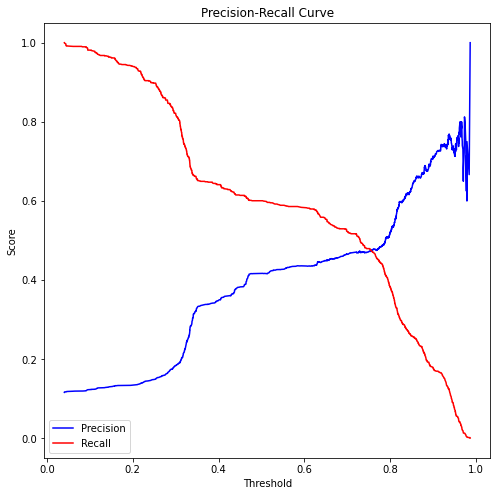

In [10]:
find_thresh(rfc_tuned_smote, X_test, y_test)

In [11]:
y_proba_test_rfc_tuned = rfc_tuned_smote.predict_proba(X_test)[:,1]
y_pred_class_test_rfc_tuned = binarize([y_proba_test_rfc_tuned], 0.33)[0]
evaluationMetrics(y_test, y_pred_class_test_rfc_tuned)

In [12]:
print(classification_report(y_test, y_pred_class_test_rfc_tuned))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82      7279
           1       0.26      0.71      0.38       959

    accuracy                           0.72      8238
   macro avg       0.60      0.72      0.60      8238
weighted avg       0.87      0.72      0.77      8238



In [13]:
y_proba_train_rfc_tuned = rfc_tuned_smote.predict_proba(X_train)[:,1]
y_pred_class_train_rfc_tuned = binarize([y_proba_train_rfc_tuned], 0.33)[0]

In [14]:
print(classification_report(y_train, y_pred_class_train_rfc_tuned))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     29269
           1       0.25      0.74      0.37      3681

    accuracy                           0.72     32950
   macro avg       0.60      0.73      0.60     32950
weighted avg       0.88      0.72      0.77     32950



## XGB Classifier

In [15]:
xgb_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 4, learning_rate = 0.1, 
                                            max_depth = 9, n_estimators = 200,
                                            reg_alpha = 10, reg_lambda = 10,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

'Best Threshold=0.4773365259170532, F-Score=0.49746192893401014'

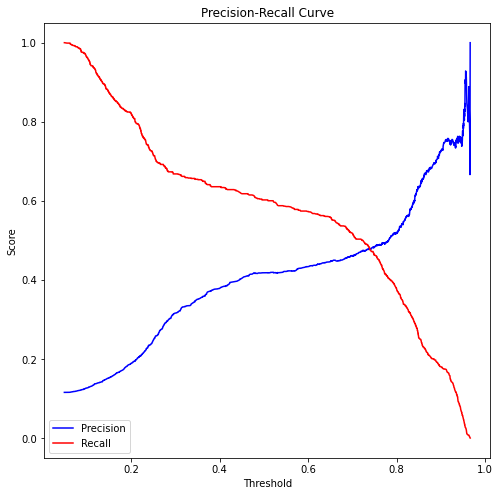

In [16]:
find_thresh(xgb_tuned_smote, X_test, y_test)

In [17]:
y_proba_test_xgb_tuned = xgb_tuned_smote.predict_proba(X_test)[:,1]
y_pred_class_test_xgb_tuned = binarize([y_proba_test_xgb_tuned], 0.33)[0]
evaluationMetrics(y_test, y_pred_class_test_xgb_tuned)

In [18]:
confusion_matrix(y_test, y_pred_class_test_xgb_tuned)

array([[6030, 1249],
       [ 328,  631]])

In [19]:
print(classification_report(y_test, y_pred_class_test_xgb_tuned))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      7279
           1       0.34      0.66      0.44       959

    accuracy                           0.81      8238
   macro avg       0.64      0.74      0.66      8238
weighted avg       0.88      0.81      0.83      8238



In [20]:
y_proba_train_xgb_tuned = xgb_tuned_smote.predict_proba(X_train)[:,1]
y_pred_class_train_xgb_tuned = binarize([y_proba_train_xgb_tuned], 0.33)[0]

In [21]:
print(classification_report(y_train, y_pred_class_train_xgb_tuned))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     29269
           1       0.33      0.69      0.45      3681

    accuracy                           0.81     32950
   macro avg       0.64      0.76      0.67     32950
weighted avg       0.88      0.81      0.84     32950



In [22]:
metric_thresh['Recall'] = recall
metric_thresh['Precision'] = prec

In [23]:
metric_thresh

,Recall,Precision
Random Forest Classifier (with SMOTE),0.712200,0.255136
XGB Classifier (with SMOTE),0.657977,0.335638


<p style="font-family:'Courier New'">Cara saya menentukan threshold berdasarkan dari recall dan precision merujuk dengan paper [1], dimana menurut Hayes, dkk dan juga dibahas di paper [2] oleh Leuser, dkk:
    
* $recall > 60\%$ (<i>acceptable</i>) 
* $recall > 70\%$ (<i>good</i>)
* $recall > 80\%$ (<i>excelent</i>) <br>

<p style="font-family:'Courier New'">sedangkan untuk precision:
    
* $precision > 20\%$ (<i>acceptable</i>) 
* $precision > 30\%$ (<i>good</i>)
* $precision > 40\%$ (<i>excelent</i>) 

<p style="font-family:'Courier New'">Berhubung objektif metrik saya adalah recall, maka yang saya butuhkan adalah recall yang bagus. Yang artinya dalam kasus ini Random Forest Classifier memadai itu. 

[1] Hayes, J.H., Dekhtyar, A.: Humans in the Traceability Loop: Can’t Live with ’em, Can’t Live without ’em. In: Proceedings of the 3rd International Workshop on Traceability in Emerging Forms of Software Engineering, pp. 20–23. ACM, New York (2005)

[2] Leuser J., Ott D. (2010) Tackling Semi-automatic Trace Recovery for Large Specifications. In: Wieringa R., Persson A. (eds) Requirements Engineering: Foundation for Software Quality. REFSQ 2010. Lecture Notes in Computer Science, vol 6182. Springer, Berlin, Heidelberg